In [11]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import time

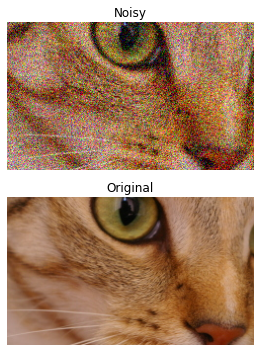

In [5]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise


original = img_as_float(data.chelsea()[100:250, 50:300])

sigma = 0.155
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
# sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
# print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title('Noisy')

ax[1].imshow(original)
ax[1].axis('off')
ax[1].set_title('Original')

fig.tight_layout()

plt.show()

In [13]:
r_noisy = noisy[:,:,0]
g_noisy = noisy[:,:,1]
b_noisy = noisy[:,:,2]

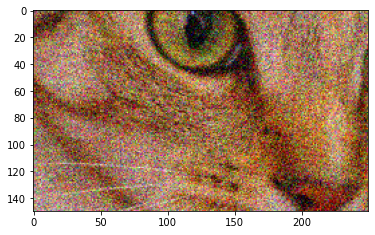

In [26]:
c = np.concatenate([r_noisy.reshape(m,n,1), g_noisy.reshape(m,n,1), b_noisy.reshape(m,n,1)], -1)
plt.imshow(c)

In [21]:
def freudenthal_grid(m, n):
    """
    Freudenthal triangulation of a m x n grid
    """
    
    def _get_idx(i, j):
        """
        get index of grid in row-major order
        """
        return j + n * i;
    
    
    X = bats.SimplicialComplex()
    
    for i in range(m-1):
        for j in range(n-1):
            k1 = _get_idx(i,j)
            k2 = _get_idx(i+1,j)
            k3 = _get_idx(i,j+1)
            k4 = _get_idx(i+1,j+1)
            X.add_recursive([k1,k2,k4])
            X.add_recursive([k1,k3,k4])

    return X

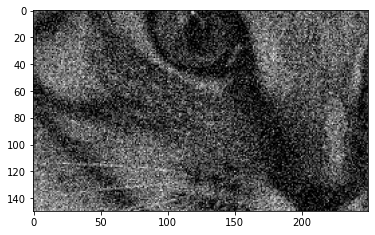

In [24]:
m = original[:,:,0].shape[0]
n = original[:,:,0].shape[1]
X = freudenthal_grid(m, n)
f = r_noisy
plt.imshow(f)

In [29]:
t0 = time.monotonic()
vals, imap = bats.lower_star_filtration(X, f.flatten())
t1 = time.monotonic()
print("time to extend: {} sec.".format(t1 - t0))

t0 = time.monotonic()
F = bats.FilteredSimplicialComplex(X, vals)
t1 = time.monotonic()
print("time to construct filtration: {} sec.".format(t1 - t0))

t0 = time.monotonic()
R = bats.reduce(F, bats.F2())
t1 = time.monotonic()
print("time to reduce: {} sec.".format(t1 - t0))

time to extend: 0.03305563800040545 sec.
time to construct filtration: 0.08009146199992756 sec.
time to reduce: 0.38966455799982214 sec.


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Birth', ylabel='Death'>)

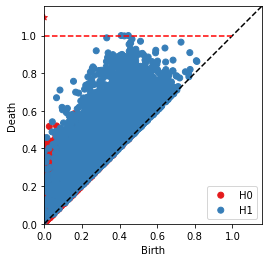

In [30]:
ps = R.persistence_pairs(0, False) +  R.persistence_pairs(1, False)
bats.persistence_diagram(ps)

## Time comparison

In [33]:
lr = 0.1 # persistence penalty

f = r_noisy
f = f.flatten()
t0 = time.monotonic()
vals, imap = bats.lower_star_filtration(X, f)
F = bats.FilteredSimplicialComplex(X, vals)
R = bats.reduce(F, bats.F2())
t1 = time.monotonic()
print("initialization: {} sec.".format(t1-t0))

for i in range(10):
    # extend filtration
    t0a = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, f)
    t1 = time.monotonic()
    print("\textension: {} sec.".format(t1 - t0a))
    # compute persistence
    t0 = time.monotonic()
    R.update_filtration(vals)
    t1 = time.monotonic()
    print("\tupdate: {} sec.".format(t1 - t0))
    # get 1-dimensional pairs
    t0 = time.monotonic()
    ps = R.persistence_pairs(1)
    t1a = time.monotonic()
    print("\tpairs: {} sec.".format(t1a - t0))
    print("iter {}: {} sec.".format(i, t1a-t0a))
    for p in ps:
        d = p.dim()
        bi = imap[d][p.birth_ind()] # maps birth_ind to pixel where it appeared
        di = imap[d+1][p.death_ind()] # maps death_ind to pixel where it appeared
        f[bi] = f[bi] - lr
        f[di] = f[di] + lr

initialization: 0.7512412989999575 sec.
	extension: 0.1323434219993942 sec.
	update: 0.05181879400061007 sec.
	pairs: 0.13196552799945493 sec.
iter 0: 0.3163224209993132 sec.
	extension: 0.10778949300038221 sec.
	update: 0.12590330700004415 sec.
	pairs: 0.13175347699962003 sec.
iter 1: 0.36568365400034963 sec.
	extension: 0.211176370999965 sec.
	update: 0.2680415760005417 sec.
	pairs: 0.1395295909997003 sec.
iter 2: 0.6190106969997942 sec.
	extension: 0.11091757800022606 sec.
	update: 0.47306555599971034 sec.
	pairs: 0.12703361799958657 sec.
iter 3: 0.7113053189996208 sec.
	extension: 0.14545670999996219 sec.
	update: 1.6496862350004449 sec.
	pairs: 0.12662608199934766 sec.
iter 4: 1.9220051459997194 sec.
	extension: 0.12932157300019753 sec.
	update: 2.836872910999773 sec.
	pairs: 0.22668851300022652 sec.
iter 5: 3.193332692000695 sec.
	extension: 0.21485914799995953 sec.
	update: 5.026992958999472 sec.
	pairs: 0.2761537420001332 sec.
iter 6: 5.519131355000354 sec.
	extension: 0.139165

In [34]:
lr = 0.1 # persistence penalty

f = r_noisy
f = f.flatten()
t0 = time.monotonic()
vals, imap = bats.lower_star_filtration(X, f)
F = bats.FilteredSimplicialComplex(X, vals)
R = bats.reduce(F, bats.F2())
t1 = time.monotonic()
print("initialization: {} sec.".format(t1-t0))

for i in range(20):
    # extend filtration
    t0a = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, f)
    t1 = time.monotonic()
    print("\textension: {} sec.".format(t1 - t0a))
    # compute persistence
    t0 = time.monotonic()
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("\tupdate: {} sec.".format(t1 - t0))
    # get 1-dimensional pairs
    t0 = time.monotonic()
    ps = R.persistence_pairs(1)
    t1a = time.monotonic()
    print("\tpairs: {} sec.".format(t1a - t0))
    print("iter {}: {} sec.".format(i, t1a-t0a))
    for p in ps:
        d = p.dim()
        bi = imap[d][p.birth_ind()] # maps birth_ind to pixel where it appeared
        di = imap[d+1][p.death_ind()] # maps death_ind to pixel where it appeared
        f[bi] = f[bi] - lr
        f[di] = f[di] + lr

initialization: 0.7712512739999511 sec.
	extension: 0.14662389799923403 sec.
	update: 0.6415344130000449 sec.
	pairs: 0.1306680289999349 sec.
iter 0: 0.9190605989997493 sec.
	extension: 0.12936082200030796 sec.
	update: 0.8261849950004034 sec.
	pairs: 0.22779171299953305 sec.
iter 1: 1.1836260330001096 sec.
	extension: 0.141785284999969 sec.
	update: 0.666733271999874 sec.
	pairs: 0.175213707999319 sec.
iter 2: 0.9839783549996355 sec.
	extension: 0.12558361100036564 sec.
	update: 0.5989868830001797 sec.
	pairs: 0.144946228999288 sec.
iter 3: 0.869723177999731 sec.
	extension: 0.13184108099994774 sec.
	update: 0.5996207529997264 sec.
	pairs: 0.1461495069997909 sec.
iter 4: 0.877811778999785 sec.
	extension: 0.18408091699984652 sec.
	update: 0.6630977689992505 sec.
	pairs: 0.13920631099972525 sec.
iter 5: 0.9866559470001448 sec.
	extension: 0.12497993800025142 sec.
	update: 0.5895533450002404 sec.
	pairs: 0.13583501300036005 sec.
iter 6: 0.8506015740003932 sec.
	extension: 0.116448837999

## See optimizing result

In [35]:
lr = 0.1 # persistence penalty
opt_result = []

for f in [r_noisy, g_noisy, b_noisy]:
    f = f.flatten()
    for i in range(20):
        # extend filtration
        vals, imap = bats.lower_star_filtration(X, f)
        # compute persistence
        F = bats.FilteredSimplicialComplex(X, vals)
        R = bats.reduce(F, bats.F2())
        # get 1-dimensional pairs
        ps = R.persistence_pairs(1)
        for p in ps:
            d = p.dim()
            bi = imap[d][p.birth_ind()] # maps birth_ind to pixel where it appeared
            di = imap[d+1][p.death_ind()] # maps death_ind to pixel where it appeared
            f[bi] = f[bi] - lr
            f[di] = f[di] + lr
    
    opt_result.append(f)

In [53]:
max(imap[2])

37497

In [55]:
m*n

37500

In [47]:
opt = []
for r in opt_result:
    # print(r.shape)
    r = r.reshape((m,n,1))
    # print(r.shape)
    opt.append(r)
    
f_opt = np.concatenate(opt, -1)
f_opt.shape

(150, 250, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


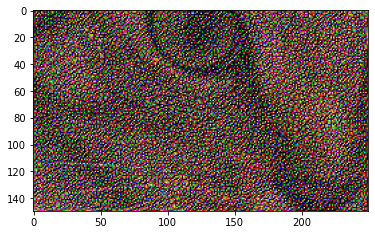

In [48]:
plt.imshow(f_opt)